**Homework 3: Implementation of a classifier perceptron for binary classification**

Universidad de Monterrey

Joel Enrique Díaz Villanueva

IMT

Dr. Andrés Hernández Gutiérrez

Monterrey, N.L., 19 de septiembre del 2024

In [26]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo # Paquete para importar conjuntos de datos desde el repositorio de machine learning de UC Irvine.
import pandas as pd # Proporciona estructuras de datos y herramientas para el análisis eficiente de datos tabulares, series temporales y matrices etiquetadas o no etiquetadas.
import matplotlib.pyplot as plt # Está diseñada para crear gráficos y visualizaciones interactivas de datos, por ejemplo, para trazar las curvas de aprendizaje y evaluar el proceso de entrenamiento.
import numpy as np # Se utiliza para crear arreglos multidimensionales y realizar operaciones matemáticas, lógicas y de álgebra lineal, además de la generación de números aleatorios.
import tensorflow as tf #  Librería desarrollada por Google, es de las más utilizadas para diseñar, entrenar, validar y probar el desarrollo de una red neuronal.
from sklearn.model_selection import train_test_split # Esta biblioteca proporciona el método train_test_split para dividir el conjunto de datos inicial en los conjuntos de entrenamiento y validación.
from sklearn.preprocessing import StandardScaler # Estándariza las características eliminando la media y escalando a una varianza unitaria. (z = (x - u) / s)

Se instalan e importan las bibliotecas necesarias para el código.





In [27]:
# Download `occupancy-detection` dataset
# using the id=357
occupancy_detection = fetch_ucirepo(id=357)  # Se descarga el dataset "ocuppancy-detection".

# Build the feature and the target data sets
data = occupancy_detection.data.original # Se le asigna la variable data a los datos originales de este dataset.

Se descarga el dataset "ocuppancy-detection".



In [28]:
df = data.drop(['date', 'id'], axis=1) # Se remueven datos innecesarios como las columnas del id y la fecha.
df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce') # Se convierte todo el dataframe a valores numéricos para garantizar que no haya problemas con los cálculos posteriores.
df = df.dropna() # Se elimina cualquier fila que contenga valores NaN.

Se eliminan datos innecesarios para predecir la occupancy en una habitación.

In [29]:
df # Se visualiza el data frame.

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.180,27.2720,426.00,721.25,0.004793,1.0
1,23.150,27.2675,429.50,714.00,0.004783,1.0
2,23.150,27.2450,426.00,713.50,0.004779,1.0
3,23.150,27.2000,426.00,708.25,0.004772,1.0
4,23.100,27.2000,426.00,704.50,0.004757,1.0
...,...,...,...,...,...,...
20557,20.815,27.7175,429.75,1505.25,0.004213,1.0
20558,20.865,27.7450,423.50,1514.50,0.004230,1.0
20559,20.890,27.7450,423.50,1521.50,0.004237,1.0
20560,20.890,28.0225,418.75,1632.00,0.004279,1.0


Visualización del dataframe.

In [30]:
df.describe() # Genera un resumen estadístico del dataframe, obteniendo información como: el número de datos, promedio, desviación estándar, valor mínimo, el valor por debajo del cual se encuentra el 25%, el valor que separa a los datos en dos partes iguales, el valor por debajo del cual se encuentra el 75% de los datos y el valor máximo.

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


Se genera un resumen estadístico del dataframe, esto es importante para una detección temprana de posibles sesgos, donde cierta entrada pueda obtener un mayor peso a comparación de las demás.




In [31]:
tf.random.set_seed(4500) # Se fija una semilla para obtener respuestas similares al trabajar con números aleatorios.

Esta semilla sirve para obtener resultados similares al trabajar con números aleatorios, sin importar desde donde se trabaje.

In [32]:
X = df.drop(["Occupancy"], axis=1) # Se elimina la columna occupancy para las entradas (X).
y = df['Occupancy']  # El occupancy se convierte en la salida o Y, para predecir si esta ocupada o no la habitación.

Se establece la columna occupancy como la salida, o el objetivo a predecir, y los demás datos como las entradas.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True) # Se separan los datos de entrenamiento y prueba, corresponiendo el 80% de los datos a el entrenamiento y el resto para prueba, con un random state de 42, para obtener respuestas similares al trabajar con aleatoriedad, además de la inclusión de la función shuffle, ayuda a que exista más esparcimiento entre los datos.

Se separan los datos de entrada y salida como datos de entrenamiento y de prueba.

In [34]:
scaler = StandardScaler() # Herramienta para estandarizar datos y evitar sesgos.
X_train = scaler.fit_transform(X_train) # Estandariza los datos de x train.
X_test = scaler.transform(X_test) # Estandariza los datos de x test.

Se estandarizan los datos de entrada para evitar sesgos.

In [35]:
from scipy.special import expit # Importación de la función logistica sigmoidal

class NeuronModel():

    def __init__(self, X, y, learning_rate=0.01, error_threshold=0.001) -> None:

        assert X.size != 0, "X cannot be empty" # Se asegura que X no este vacio.
        assert y.size != 0, "y cannot be empty" # Se asegura que Y no este vacío.
        assert learning_rate > 0, "learning rate must be positive" # Se asegura que el learning rate sea positivo.

        if not isinstance(X, np.ndarray):
            X = X.to_numpy() # Convierte X a un arreglo de numpy.

        if not isinstance(y, np.ndarray):
            y = y.to_numpy().reshape(-1,1) # Convierte y a un array de NumPy y lo reestructura como columna con las columnas que sean necesarias.

        self.X = X # Se guarda la variable X en la variable global de la clase.
        self.y = y # Se guarda la variable y en la variable global de la clase.
        self.learning_rate = learning_rate # Se guarda la variable learning_rate en la variable global de la clase.
        self.w = np.zeros((X.shape[1], 1)) # Inicializa los pesos como un vector de ceros (tantos como características tenga X) y los guarda en una variable global de la clase.
        self.b = np.zeros((1, 1))  # Incializa el sesgo en 0, y lo guarda en una variable global de la clase.
        self.N = X.shape[0] # Guarda el número de muestras de X en una variable global.
        self.J_iter = list() # Lista para almacenar la función de costo en cada iteración.
        self.stopping_tolerance = error_threshold # Parámetro para detener el entrenamiento si el error se vuelve suficientemente pequeño.

    def compute_logistic(self, w, b, X):
        return expit(X@w + b) # Calcula la función logística para una entrada X, pesos w y sesgo b.

    def compute_cost(self, y_hat, y, N):
        L = y*np.log(y_hat) + (1-y)*np.log(1-y_hat) # Función de cross entropy para el costo mínimo.
        J = -L.sum() / N # Calcula el costo promedio.
        return J # Regresa el valor de J

    def forward_propagation(self, w, b, X):
        a = self.compute_logistic(w, b, X) # Calcula la salida de la red aplicando la función logística.
        return a # Regresa el valor de a

    def backward_propagation(self, y_hat, y, w, X):
        N = X.shape[0] # Número de muestras
        gradient_w = np.multiply(y_hat - y, X).sum(axis=0)/ N # Gradiente de los pesos.
        gradient_w = gradient_w.reshape(w.shape) # Asegura que el gradiente tenga la forma de los pesos.
        gradient_b = (y_hat - y).sum() / N # Gradiente del sesgo.
        gradient_b = gradient_b.reshape(-1,1) # Asegura que el gradiente del sesgo tenga la forma correcta.
        return gradient_w, gradient_b # Regresa el valor de los gradientes calculados.

    def update_parameters(self, param, gradient):
        return np.subtract(param, np.multiply(self.learning_rate, gradient)) # Actualiza los parámetros utilizando el gradiente descendente.

    def train(self, verbose=0):

        y_hat = self.forward_propagation(self.w, self.b, self.X) # Calcula la salida inicial.
        J_prev = self.compute_cost(y_hat, self.y, self.N) # Calcula el costo inicial.
        J, current_percentage_error = 0, 100 # Inicializa el costo y el error porcentual.
        w, b = self.w, self.b # Inicializa los pesos y el sesgo.

        while current_percentage_error > self.stopping_tolerance:
            J_prev = J # Actualiza el valor de la J_Prev hasta cumplir con el error porcentual.

            y_hat = self.forward_propagation(w, b, self.X) # Se utiliza la propagación hacia delante.

            gradient_w, gradient_b = self.backward_propagation(y_hat,
                                                               self.y,
                                                               w,
                                                               self.X) # Calcula los gradientes.

            w = self.update_parameters(w, gradient_w) # Actualiza los pesos.
            b = self.update_parameters(b, gradient_b) # Actualiza el sesgo.

            y_hat = self.forward_propagation(w, b, self.X) # Se utiliza la propagación hacia delante con la actualización de los pesos y sesgo.
            J = self.compute_cost(y_hat, self.y, self.N) # Vuelve a calcular el costo.
            self.J_iter.append(J) # Acomoda los costos en una arreglo.

            current_percentage_error = np.abs((J - J_prev)/J)*100 # Calcula el error porcentual.

            if verbose: # Muestra el costo anterior, el actual y el error.
                print(f"J_previous: {J_prev:8.6f} \t"
                      f"J_current: {J:8.6f} \t"
                      f"Error: {current_percentage_error:8.6f}")

        self.w = w  # Asigna el valor actualizado de los pesos a una variable global de la clase.
        self.b = b  # Asigna el valor actualizado de los sesgos a una variable global de la clase.

    def predict(self, X):
        a = self.forward_propagation(self.w, self.b, X) # Realiza la predicción utilizando la propagación hacia delante.
        return a # Regresa el valor de la predicción.

    def plot_cost_function(self):
        plt.plot(self.J_iter) # Grafica la actualización de la función de costo
        plt.xlabel('Iteration') # Asigna el eje x como el número de iteraciones
        plt.ylabel(r"$J_{\mathbf{w}}$") # Asigna el eje y como la actualización de la función de costo

    def evaluate(self, y_hat, y):

        if not isinstance(y, np.ndarray):
            y = y.to_numpy().reshape(-1,1) # De ser necesario, convierte y en un arreglo.

        y_hat[y_hat >= 0.5] = 1 # Si la probabilidad es mayor a 0.5 o el 50%, la toma como un 1 lógico (True).
        y_hat[y_hat < 0.5] = 0 # Si la probabilidad es menor a 0.5 o al 50%, la toma como un 0 lógico (False).

        err = np.where((np.abs(y - y_hat) > 0) == True)[0] # Calcula el error entre los datos reales y los predichos.

        return 1-err.shape[0]/y.shape[0] # Cálcula y devuelve la precisión del modelo.

    def get_parameters(self):
        return np.vstack((self.w, self.b)) # Devuelve el peso y el sesgo en un arreglo.

Implementación de backpropagation para actualizar los pesos y sesgos del modelo. Calcula la función de costo utilizando cross-entropy.

In [36]:
model = NeuronModel(X=X_train, y=y_train, learning_rate=1, error_threshold=0.01) # Crea un modelo utilizando la clase NeuronModel, utilizando los datos de entrenamiento de entrada y salida, una tasa de aprendizaje alta y con un umbral de error de 0.01
model.train(verbose=1) # Entrenamiento del modelo, mostrando detalles del progreso

J_previous: 0.000000 	J_current: 0.434288 	Error: 100.000000
J_previous: 0.434288 	J_current: 0.337854 	Error: 28.542931
J_previous: 0.337854 	J_current: 0.284542 	Error: 18.736343
J_previous: 0.284542 	J_current: 0.249663 	Error: 13.970439
J_previous: 0.249663 	J_current: 0.224651 	Error: 11.133710
J_previous: 0.224651 	J_current: 0.205647 	Error: 9.240989
J_previous: 0.205647 	J_current: 0.190621 	Error: 7.882361
J_previous: 0.190621 	J_current: 0.178390 	Error: 6.856745
J_previous: 0.178390 	J_current: 0.168207 	Error: 6.053642
J_previous: 0.168207 	J_current: 0.159579 	Error: 5.407044
J_previous: 0.159579 	J_current: 0.152161 	Error: 4.874943
J_previous: 0.152161 	J_current: 0.145707 	Error: 4.429250
J_previous: 0.145707 	J_current: 0.140035 	Error: 4.050434
J_previous: 0.140035 	J_current: 0.135007 	Error: 3.724473
J_previous: 0.135007 	J_current: 0.130516 	Error: 3.441032
J_previous: 0.130516 	J_current: 0.126478 	Error: 3.192321
J_previous: 0.126478 	J_current: 0.122827 	Error: 

Se muestra de manera manual, con un learning rate muy alto, la actualización de la función de pérdida aplicándola en forward propagation, hasta llegar a minimizarla con un error menor a 0.01.

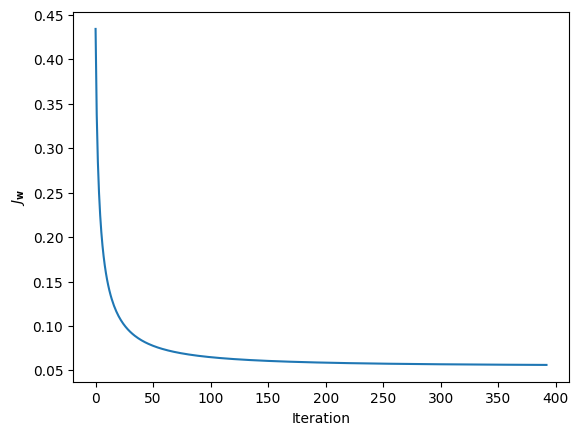

In [37]:
model.plot_cost_function() # Gráfica de la evolución de función de costo a través de las iteraciones.

Muestra el valor de la función de pérdida a través de las iteraciones, 400 aproximadamente, en este caso.

In [38]:
y_predictions = model.predict(X=X_test) # Se utilizan los datos de prueba para realizar predicciones.

Se realizan predicciones con los datos de prueba.

In [39]:
model.get_parameters() # Se obtienen los parametros del modelo, como el peso de cada entrada y el sesgo.

array([[-0.72815137],
       [ 0.20614421],
       [ 4.29723527],
       [ 0.95814606],
       [ 0.17301175],
       [-3.70904074]])

Se muestran los pesos y el sesgo del modelo. Los cuales coinciden con el código donde se implementa TensorFlow, en cuanto al orden de los pesos en valor absoluto (1. Luz, 2. CO2, 3. Temperatura, etc.).

In [40]:
model.evaluate(y_hat=y_predictions, y=y_test) # Se evalúa la precisión del modelo utilizando las predicciones y las etiquetas reales del conjunto de prueba.

0.9892996108949417

Se evalúa la exactitud del modelo, comparando las predicciones contra los valores reales, con los datos de prueba.




In [41]:
from sklearn.metrics import confusion_matrix
y_predictions = model.predict(X_test) > 0.5 # Se convierten las probabilidades en predicciones binarias (0 o 1).
c_matrix = confusion_matrix(y_true=y_test, y_pred=y_predictions) # Se calcula la matriz de confusión comparando los valores reales con las predicciones.

Se establece la matriz de confusión.

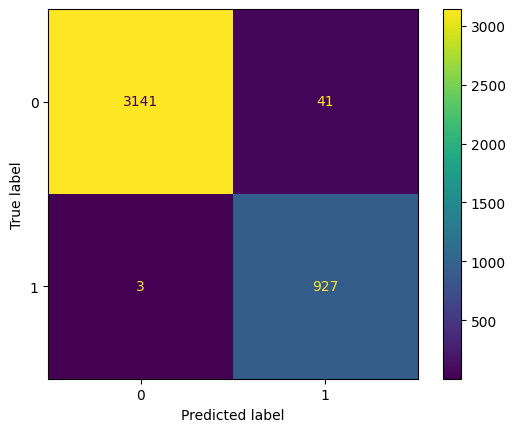

In [43]:
display_matrix = ConfusionMatrixDisplay(confusion_matrix=c_matrix) # Se crea el display para la matriz de confusión
display_matrix.plot() # Se muestra la matriz de confusión

Se observa un total de 3141 verdaderos negativos, 41 falsos negativos y un total de 3 falsos negativos y 927 verdaderos positivos utilizando los datos de prueba y los predichos.

In [42]:
def get_performance_metrics(c_matrix):
    tn, fp, fn, tp = c_matrix[0][0], c_matrix[0][1], c_matrix[1][0], c_matrix[1][1] # Se obtienen los datos de la matriz de confusión, (verdaderos negativos, falsos positivos, falsos negativos y verdaderos positivos).

    accuracy = (tp + tn) / (tp + tn + fp + fn) # Exactitud.
    precision = tp / (tp + fp) # Precisión.
    recall = tp / (tp + fn) # Sensibilidad o Recall.
    specificity = tn / (tn + fp) # Especificidad.
    f1_score = 2 * (precision * recall)/(precision + recall) # F1-score.
    return accuracy, precision, recall, specificity, f1_score # Se devuelven los valores de las métricas de rendimiento.

accuracy, precision, recall, specificity, f1_score = get_performance_metrics(c_matrix) # Se obtienen las métricas de desempeño usando la matriz de confusión.

# Se imprimen los resultados con 6 decimales
print(f"Accuracy: {accuracy:0.6f}")
print(f"Precision: {precision:0.6f}")
print(f"Recall: {recall:0.6f}")
print(f"Specificity: {specificity:0.6f}")
print(f"F1-score: {f1_score:0.6f}")

Accuracy: 0.989300
Precision: 0.957645
Recall: 0.996774
Specificity: 0.987115
F1-score: 0.976818


El modelo muestra un rendimiento excelente, con métricas que indican, muy pocos errores (alta precisión y exactitud), además de muy buena capacidad para detectar correctamente tanto las habitaciones ocupadas como las no ocupadas.

**Referencias:**

Scikit-Learn. (n.d.) StandardScaler. Recuperado el 18 de septiembre del 2024 de: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessingStandardScaler.html

SciPy. (n.d.). scipy.special.expit. Recuperado el 18 de septiembre del 2024 de: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html

Saturn Cloud. (2023). Understanding the Differences Between Numpy Reshape(-1, 1) and Reshape(1, -1). Recuperado el 18 de septiembre del 2024 de: https://saturncloud.io/blog/understanding-the-differences-between-numpy-reshape1-1-and-reshape1-1/

Shah, N. (2018). Introduction to NumPy, Pandas and Matplotlib. Recuperado de: https://www.kaggle.com/code/chats351/introduction-to-numpy-pandas-and-matplotlib